In [1]:
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
import numpy as np


In [2]:
base_path = '/Users/maltegenschow/Documents/Uni/SoSe23/Data Science Project/data/Landsat/LC08_L1TP_192027_20220913_20220922_02_T1/LC08_L1TP_192027_20220913_20220922_02_T1_'

In [3]:
#import bands as separate 1 band raster
band4 = rasterio.open(base_path+'B4.tif') #red
band5 = rasterio.open(base_path+'B5.tif') #nir

band5.height, band5.width

(8091, 7991)

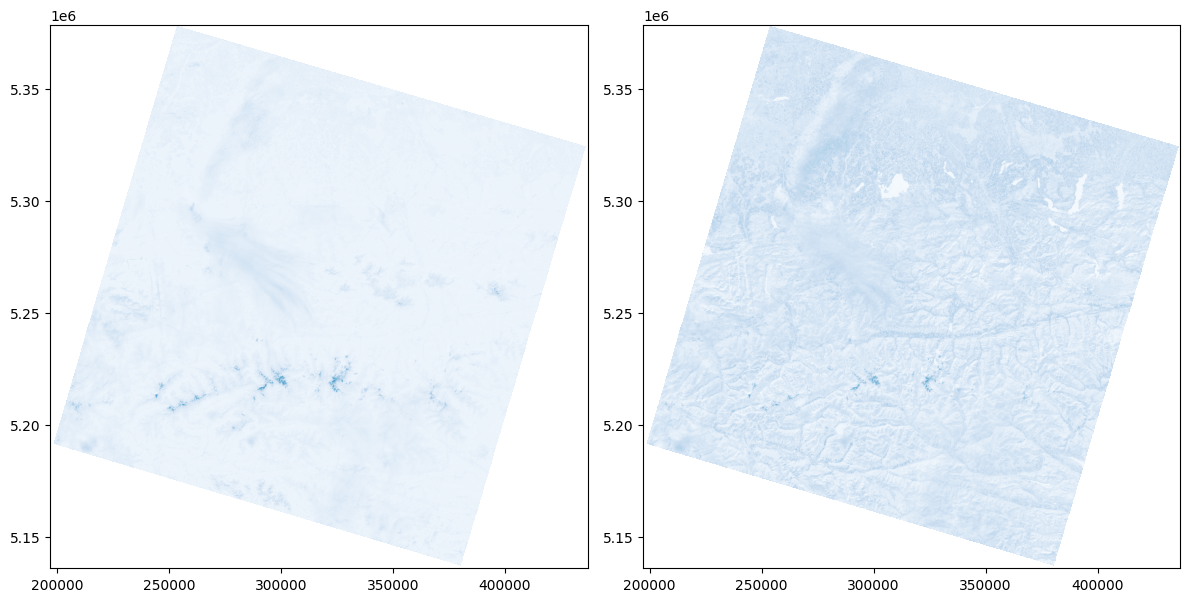

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot.show(band4, ax=ax1, cmap='Blues') #red
plot.show(band5, ax=ax2, cmap='Blues') #nir
fig.tight_layout()

In [5]:
#generate nir and red objects as arrays in float64 format
red = band4.read(1).astype('float64')
nir = band5.read(1).astype('float64')
nir

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
#ndvi calculation, empty cells or nodata cells are reported as 0
ndvi=np.where(
    (nir+red)==0., 
    0, 
    (nir-red)/(nir+red))
ndvi[:5,:5]

/var/folders/nm/v6v65dzj5sj277njyc15pbjm0000gn/T/ipykernel_24559/743346378.py:5: RuntimeWarning: invalid value encountered in divide
  (nir-red)/(nir+red))


array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [7]:
#export ndvi image
ndviImage = rasterio.open('ndviImage.tif','w',driver='Gtiff',
                          width=band4.width, 
                          height = band4.height, 
                          count=1, crs=band4.crs, 
                          transform=band4.transform, 
                          dtype='float64')
ndviImage.write(ndvi,1)
ndviImage.close()

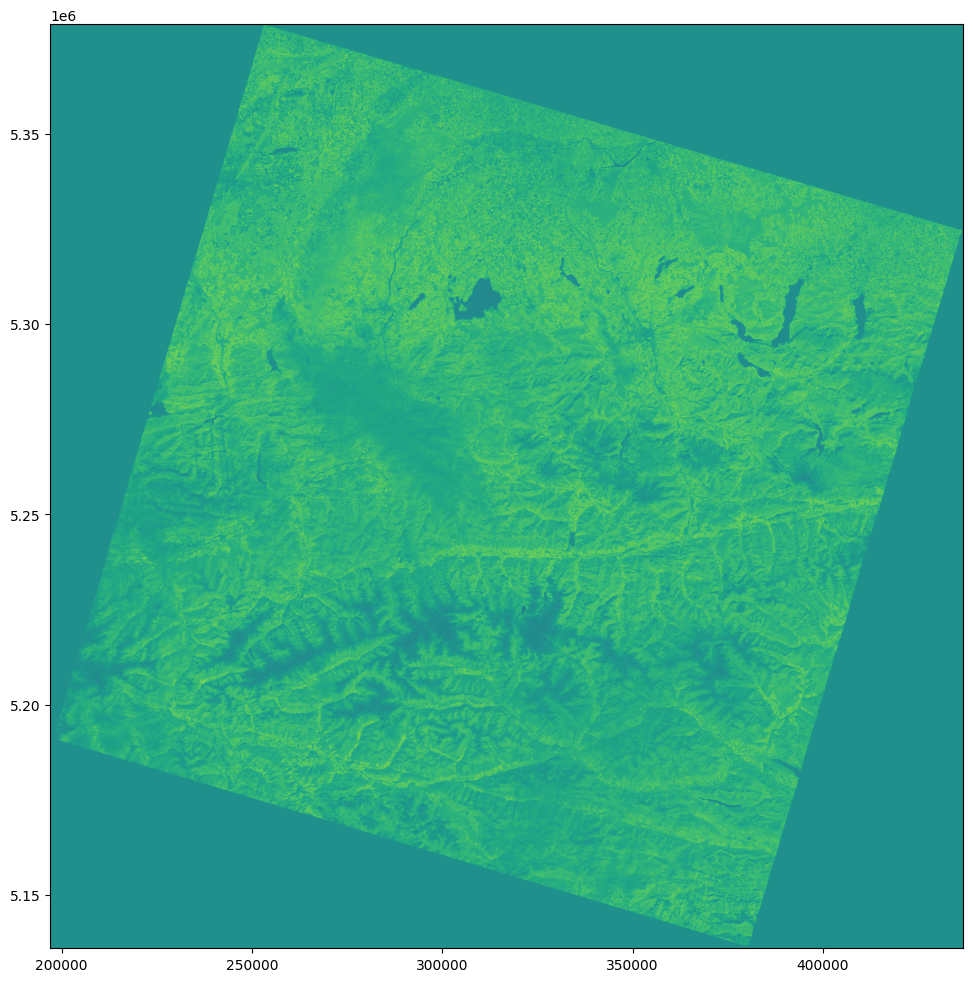

<Axes: >

In [8]:
#plot ndvi
ndvi = rasterio.open('ndviImage.tif')
fig = plt.figure(figsize=(18,12))
plot.show(ndvi)

### Subset to Munich

In [9]:
bbox_4326 = (11.576947,48.128678,11.604069,48.149555)
import rasterio.warp
[xmin, xmax], [ymin, ymax] = rasterio.warp.transform('EPSG:4326', 'EPSG:32633', [bbox_4326[0], bbox_4326[2]], [bbox_4326[1], bbox_4326[3]])
bbox = (xmin, ymin, xmax, ymax)
bbox

(245307.66814426915, 5336270.96232869, 247427.9543643659, 5338501.450638588)

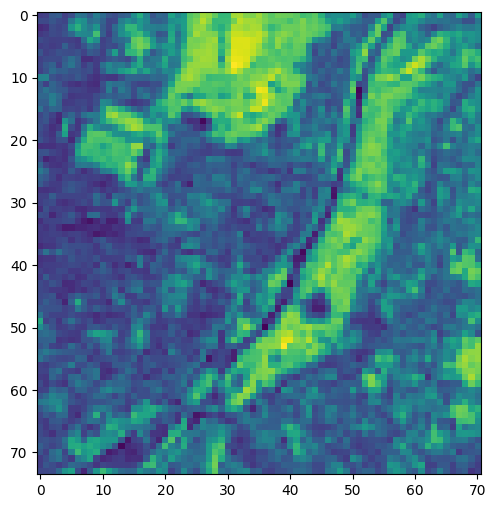

In [10]:
from rasterio.windows import from_bounds
with rasterio.open('ndviImage.tif') as src:
    # Get the window corresponding to the bounding box
    window = from_bounds(*bbox, src.transform)

    # Read the subset of the raster data as a numpy array
    subset = src.read(window=window)

    # Update the metadata of the new GeoTIFF to reflect the subset
    meta = src.meta
    meta.update({
        'width': window.width,
        'height': window.height,
        'transform': rasterio.windows.transform(window, src.transform)
    })

# Write the subset of the raster data to a new GeoTIFF file
with rasterio.open('my_subset.tif', 'w', **meta) as dst:
   dst.write(subset)
fig, ax = plt.subplots(figsize=(12, 6))
plt.imshow(subset[0])